In [1]:
import xarray as xr
import geopandas as gpd
import numpy as np
import pandas as pd

from fastkml import kml
from shapely.geometry import shape
from shapely.ops import unary_union

# Example
* Get the NWM COMIDs for gages in the NHDPlusV21 dataset
* Extract streamflow from NWM over the AQPI domain

In [2]:
# Files
aqpi_bounds_kml_file='/Users/wcurrier/Downloads/Atmospheric Model.kml'
NHD = '/Users/wcurrier/Downloads/NHDPlusV21_National_Seamless_Flattened_Lower48.gdb' 
# Key is that is NHDPlusv21
# Had to use BurnLineEvent - not FlowLine
# It’s a line feature used to enforce or modify flow paths during the hydrography dataset creation.
# Essentially, BurnLineEvent features represent corrections or artificial "burn-in" flow lines that are added or modified to improve network connectivity.
# They are used to "burn in" or embed streams or flowlines into elevation data or to correct network topology, such as fixing disconnected reaches or adding missing stream segments.
# This process ensures that flow routing is hydrologically consistent

In [3]:
# Load in KML file to get Lat Lon Bounds of AQPI domain
# In case you don't have these packages:

# Reuslts:

#Bounds:
#Min Latitude: 35.61787120861296
#Max Latitude: 40.2028753676532
#Min Longitude: -125.5904643983031
#Max Longitude: -119.0914300520682
 
with open(aqpi_bounds_kml_file, "r") as f:
    kml_data = f.read()

k = kml.KML()
k.from_string(kml_data.encode('utf-8'))

features = list(k.features())
sub_features = list(features[0].features())
geoms = [f.geometry for f in sub_features]

unioned = unary_union(geoms)
minx, miny, maxx, maxy = unioned.bounds
print(f"Bounds:\nMin Latitude: {miny}\nMax Latitude: {maxy}\nMin Longitude: {minx}\nMax Longitude: {maxx}")

Bounds:
Min Latitude: 35.61787120861296
Max Latitude: 40.2028753676532
Min Longitude: -125.5904643983031
Max Longitude: -119.0914300520682


<AxesSubplot:>

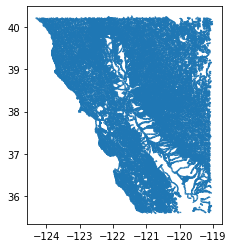

In [5]:
# Stream Network/BurLineEvent
gdf=gpd.read_file(NHD,layer='BurnLineEvent')
gdf_sub=gdf.cx[minx:maxx, miny:maxy]  #Subset to AQPI domain
gdf_sub.plot()

<AxesSubplot:>

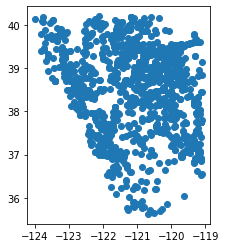

In [7]:
# Gages in NHDPLusv21
gdf_gages=gpd.read_file(NHD,layer='Gage')
gdf_gages_sub=gdf_gages.cx[minx:maxx, miny:maxy] #Subset to AQPI domain
gdf_gages_sub.plot()

# Connect Gages and Stream Network based on COMID and the Gage Lat Lon

In [9]:
from shapely.ops import nearest_points

# Build a spatial index
flowlines_sindex = gdf_sub.sindex

def find_nearest_flowline(gage_point):
    # Get candidate matches using spatial index (fast bounding box check)
    possible_matches_index = list(flowlines_sindex.nearest(gage_point.bounds, 1))
    possible_matches = gdf_sub.iloc[possible_matches_index]
    
    # Compute real nearest using geometry
    nearest_geom = possible_matches.geometry.distance(gage_point).idxmin()
    return possible_matches.loc[nearest_geom]

# Apply to each gage
nearest_flowlines = gdf_gages_sub['geometry'].apply(find_nearest_flowline)

# Merge attributes back
gages_with_flowlines = gdf_gages_sub.copy()
gages_with_flowlines[['COMID']] = nearest_flowlines[['COMID']].values

/Users/wcurrier/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if sys.path[0] == '':


# Plot the Result

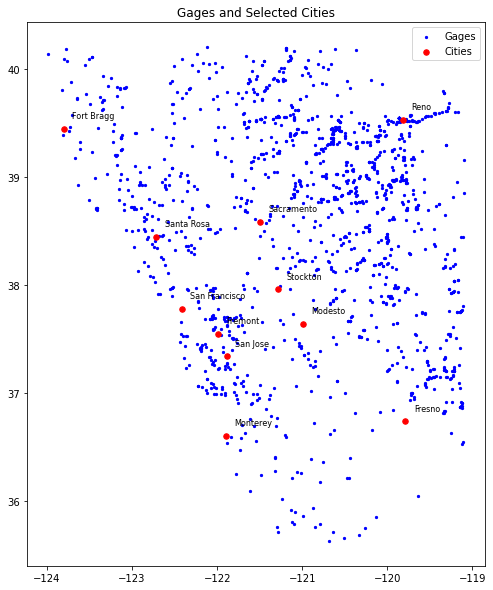

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Your gages data, assumed already in NAD83 (EPSG:4269)
# gdf_sub = ...

# Define cities and their coordinates (lat, lon)
cities = {
    "Fort Bragg": (39.445, -123.805),
    "Santa Rosa": (38.440, -122.714),
    "San Francisco": (37.774, -122.419),
    "Fremont": (37.548, -121.988),
    "San Jose": (37.338, -121.886),
    "Monterey": (36.600, -121.894),
    "Stockton": (37.957, -121.290),
    "Reno": (39.529, -119.814),
    "Sacramento": (38.581, -121.494),
    "Modesto": (37.639, -120.996),
    "Fresno": (36.737, -119.787)
}

# Create GeoDataFrame from city locations
import pandas as pd
from shapely.geometry import Point

city_gdf = gpd.GeoDataFrame(
    pd.DataFrame(cities.items(), columns=["City", "Coords"]),
    geometry=[Point(lon, lat) for lat, lon in cities.values()],
    crs="EPSG:4269"
)

# Plot
fig, ax = plt.subplots(figsize=(10, 10))
gages_with_flowlines.plot(ax=ax, color='blue', markersize=5, label="Gages")
city_gdf.plot(ax=ax, color='red', markersize=30, label="Cities")

# Add city labels
for x, y, label in zip(city_gdf.geometry.x, city_gdf.geometry.y, city_gdf["City"]):
    ax.text(x + 0.1, y + 0.1, label, fontsize=8)

ax.set_title("Gages and Selected Cities")
ax.legend()
plt.show()

# Double check I really am grabbing the right COMID/feature_id

In [19]:
# Need NWS heights
# Need RouteLink to double check I have the right COMID - check
gages_gdf=gages_with_flowlines.copy()

# RouteLINK_CONUS is a file that already did this mapping but isn't for all gages

# Read the RouteLink_CONUS.csv while skipping comment lines
routelink_df = pd.read_csv(
    "/Users/wcurrier/Downloads/csv_4/RouteLink_CONUS.csv",
    comment='#'  # skips all lines beginning with '#'
)

# Ensure matching types
routelink_df['nwm_feature_id'] = routelink_df['nwm_feature_id'].astype(str)
gages_gdf['COMID'] = gages_gdf['COMID'].astype(str)

# Merge the datasets
merged = pd.merge(
    gages_gdf, routelink_df,
    left_on="COMID", right_on="nwm_feature_id",
    how="left",  # keep only gages
    suffixes=('_gage', '_routelink')
)

import numpy as np

# Calculate raw distance in degrees
merged['lat_diff'] = np.abs(merged['LatSite'] - merged['latitude'])
merged['lon_diff'] = np.abs(merged['LonSite'] - merged['longitude'])

# Optionally, calculate haversine distance (in meters)
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # radius of Earth in meters
    phi1, phi2 = radians(lat1), radians(lat2)
    dphi = radians(lat2 - lat1)
    dlambda = radians(lon2 - lon1)
    a = sin(dphi/2)**2 + cos(phi1)*cos(phi2)*sin(dlambda/2)**2
    return 2*R*atan2(sqrt(a), sqrt(1 - a))

merged['haversine_m'] = merged.apply(
    lambda row: haversine(row['LatSite'], row['LonSite'], row['latitude'], row['longitude'])
    if not pd.isnull(row['latitude']) else np.nan,
    axis=1
)

# Define a threshold for "close" (e.g., within 100 meters)
distance_threshold = 500  # meters

# Rows with no match
no_match = merged[merged['nwm_feature_id'].isna()]

# Rows with large spatial difference (e.g., > 500 meters)
far_apart = merged[merged['haversine_m'] > distance_threshold]

# Filter to only those gages where match is spatially close
close_matches = merged[merged['haversine_m'] <= distance_threshold]
close_matches

In [35]:
# Define the station name as a variable
station_name = 'DEER C NR VINA CA'

# Filter the row for that station
row = far_apart[far_apart['STATION_NM'] == station_name]

# Print details
if not row.empty:
    print(f"Details for station: {station_name}")
    print(f"  LatSite     (gage): {row['LatSite'].values[0]}")
    print(f"  LonSite     (gage): {row['LonSite'].values[0]}")
    print(f"  latitude    (RouteLink): {row['latitude'].values[0]}")
    print(f"  longitude   (RouteLink): {row['longitude'].values[0]}")
    print(f"  Haversine distance (m): {row['haversine_m'].values[0]:.2f}")
else:
    print(f"Station '{station_name}' not found in the DataFrame.")
    


Details for station: DEER C NR VINA CA
  LatSite     (gage): 40.01404745
  LonSite     (gage): -121.9483181
  latitude    (RouteLink): 40.020115000000004
  longitude   (RouteLink): -121.89616399999998
  Haversine distance (m): 4492.34


In [72]:
# Turns out the RouteLink latitude, longitude is for the center of the streamnetwork
# The gage LatSite LonSite is for the actual gage location

# Clean Up and write out `gages_with_flowlines`
* only need `NHDPlusv21_gages_inAQPI_w_COMID4NWM.gpkg` moving forward


In [71]:
gages_gdf=gages_with_flowlines.copy()
gages_gdf.drop(columns=['REACHCODE','REACHRESOL','FEATUREDET','Measure']) # cleanup
gages_gdf.to_file("NHDPlusv21_gages_inAQPI_w_COMID4NWM.gpkg", driver="GPKG")

# Get NWM streamflow from `gages_gdf`
* Pull out gage specific locations based on the COMID's we previously found using the NHDV2.1 network
* We can't compare NWM forecasts to gage height or NWS flood thresholds without a rating curve
    * NWM forecasts issue discharge output and flood thresholds are based on gage height
    * A rating curve takes into account each stream channels geometry. There may ways of doing this but I am not aware
    * Could develop a rating curve based on discharge/gage height measurements at each location if we wanted to
    * Forecasts from the National Water Prediction Service webpage we discussed likely come from RFC's which make a forecast in gage height by using a rating curve.
    * FWIW, gage height is what's often actually measured and discharge is approximated.

In [69]:
ds=xr.open_dataset('/Users/wcurrier/Downloads/nwm.t00z.short_range.channel_rt.f001.conus.nc') 
# This is one short term forecast. Might have to stitch them together for different forecasts
# NWM forecasts do suffer from initialization errors

# Extract units attribute from the 'streamflow' variable
streamflow_units = ds['streamflow'].attrs.get('units', 'unknown units')
# Ensure matching types
gages_gdf['COMID'] = gages_gdf['COMID'].astype(int)  # ds.feature_id is likely int64
ds_feature_ids = ds['feature_id'].values.astype(int)
# Convert streamflow to pandas Series with feature_id as index
streamflow_series = pd.Series(ds['streamflow'].values, index=ds_feature_ids)
# Map to gages_gdf by COMID
gages_gdf['streamflow'] = gages_gdf['COMID'].map(streamflow_series)

# Plot Streamflow at each Gage for the one forecast hour

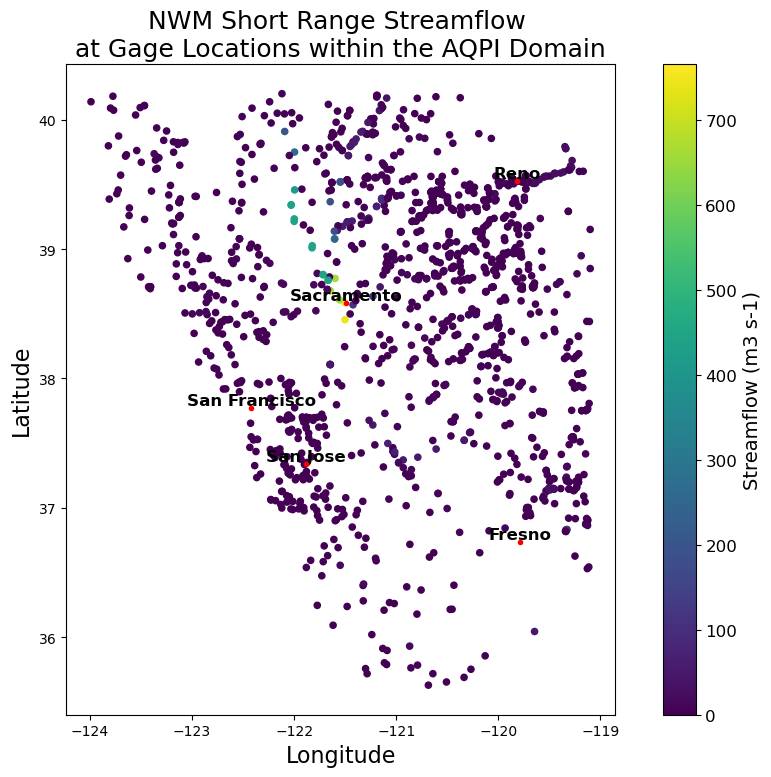

In [70]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 8))

plt.rcParams.update({
    'font.size': 14,           # Base font size
    'axes.titlesize': 16,      # Title
    'axes.labelsize': 14,      # X/Y labels
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
})

# Plot the gages with streamflow
gages_gdf.plot(
    column='streamflow',
    cmap='viridis',
    legend=True,
    ax=ax,
    markersize=20,
    legend_kwds={'label': f"Streamflow ({streamflow_units})"},
    zorder=0
)

cities = {
    "San Francisco": (-122.4194, 37.7749),
    "Sacramento": (-121.4944, 38.5816),
    "San Jose": (-121.8863, 37.3382),
    "Reno": (-119.8138, 39.5296),
    "Fresno": (-119.7871, 36.7378),
}

for city, (lon, lat) in cities.items():
    ax.text(lon, lat, city, fontsize=12,fontweight='bold', ha='center', va='bottom', color='black',zorder=1)
    ax.plot(lon, lat, 'o', color='red', markersize=3,zorder=2)  # optional dot for city

    
ax.set_title("NWM Short Range Streamflow \nat Gage Locations within the AQPI Domain",fontsize=18)
ax.set_xlabel("Longitude",fontsize=16)
ax.set_ylabel("Latitude",fontsize=16)
plt.tight_layout()

plt.rcdefaults()
